In [1]:
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from itertools import product
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from support import query_data, unique_values
%matplotlib inline

In [2]:
db = sqlite3.connect("/data/amazon-fine-foods/amazon-fine-foods/database.sqlite")

# Visualization
The next step is to get a better understanding of the data and explore the effect of parameters from TFIDF vectorization. This is done by iterating over many different Tfidfvectorization parameters to try and visualize the effect they have. A smaller subset of the data is used to produce a clearer visualization. The following document on <a href="http://nbviewer.jupyter.org/urls/gist.githubusercontent.com/AlexanderFabisch/1a0c648de22eff4a2a3e/raw/59d5bc5ed8f8bfd9ff1f7faa749d1b095aa97d5a/t-SNE.ipynb">TSNE</a> was the main source used for the visualizations. The TSNE reduction process can take awhile when done on a large set. To start I will make a plot of the text data overall and then go to a subset approach. Note: The entire notebook takes around 10 minutes to run through.

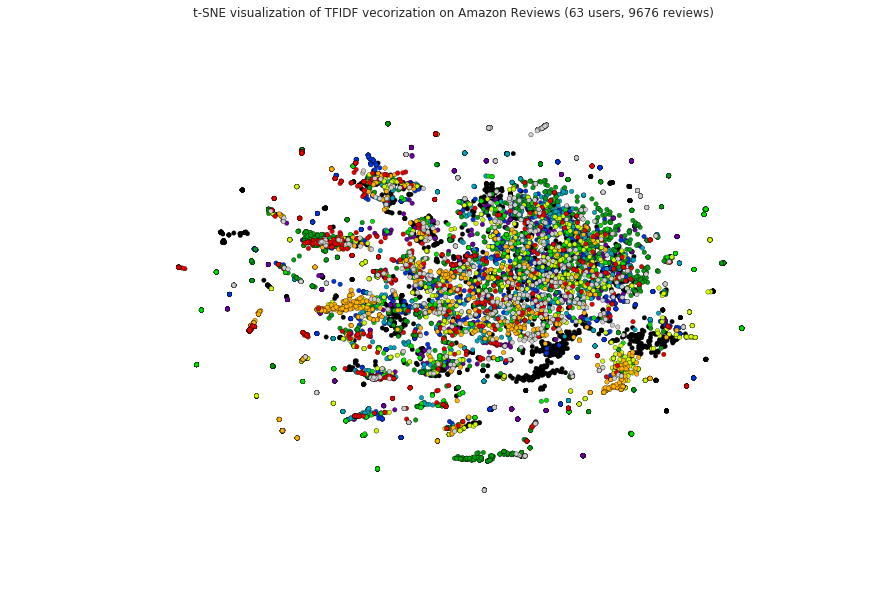

In [3]:
plt.figure(figsize=(15,10))
reviews, rev_count, user_count = query_data(100, db)
colors = unique_values(reviews)
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(reviews["Text"])
X_transformed = TruncatedSVD(n_components=50).fit_transform(matrix)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_transformed)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, cmap=plt.cm.get_cmap('spectral', 10))
plt.axis("off")
plt.title("t-SNE visualization of TFIDF vecorization on Amazon Reviews ("
                                               + str(user_count) + " users, "
                                               + str(rev_count) + " reviews)");

Look at all the pretty colors! Unfortunately this data is difficult to process in its current state. Reducing the number of users as well as isolating parameters will yield a better understanding of the data and how TFIDF works. 

In [4]:
def clean_print(params, width):
    """
    Cleanly organizes dictionaries to split once a certain legth has 
     been reached.
    Returns a string of the dictionary printed out while trying to
     avoid exceeding the specified width.
    """
    result = ["{"]
    cur_len = 0
    for key, val in params.items():
        if cur_len > width:
            result.append("\n")
            cur_len = 0
        result.append(str(key) + " : " + str(val) + ",")
        cur_len += len(result[-1])
        
    result[-1] = result[-1][:-1]
    result.append("}")
    
    return " ".join(result)

In [5]:
def review_data_visualization(count_limit, db, parameters):
    """
    Produces a series of visualizations using TSNE reduction for
     each combination of the parameters with a given review count limit.
    """
    reviews, rev_count, user_count = query_data(count_limit, db)
    colors = unique_values(reviews)
    
    # counts the number of combinations to create
    y = 1
    for k, v in parameters.items():
        y *= len(v)
        
    f, axarr = plt.subplots(round(y/2), 2, figsize=(15, 6 * round(y/2)))
    cur_cell = [0, 0]

    f.suptitle("t-SNE visualization of TFIDF vecorization on Amazon Reviews ("
                                               + str(user_count) + " users, "
                                               + str(rev_count) + " reviews)")
    
    for run in list(product(*parameters.values())):
        param = dict(zip(parameters.keys(), run))
        vectorizer = TfidfVectorizer(**param)
        
        matrix = vectorizer.fit_transform(reviews["Text"])
        
        X_transformed = TruncatedSVD(n_components=50).fit_transform(matrix)

        X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_transformed)
    
        if (round(y/2) == 1):
            curax = axarr[cur_cell[1]]
        else:
            curax = axarr[cur_cell[0], cur_cell[1]]
        curax.axis("off")
        
        curax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, cmap=plt.cm.get_cmap('spectral', 10))
        
        curax.set_title(clean_print(param, 40))
    
        if cur_cell[1] == 1:
            cur_cell[1] = 0
            cur_cell[0] += 1
        else:
            cur_cell[1] = 1

## Visualization of TFIDF Parameters

To start to get a better understanding of tfidf and the dataset, a smaller set of the data will be analyzed. The methods used to visualize the data consist of a TFIDF vectorization of the reviews and then applying an SVD and then a TNSE reduction. SVD does not produce very good results and is mainly used for TSNE to process. 

By only looking at the 7 most active reviewers we can clearly see the groupings of users' review patterns. Interestingly it seems as if users can have multiple different writing styles as users seem to have multiple clusters. 

### Ngram Range
The ngram range effects the size of ngram that is considered in the count stage. Therefore users who frequently use the same pattern of words will become more distingushed.

In [6]:
parameters = {
    'ngram_range':((1, 1), (1, 2), (2, 2), (4, 4))
}

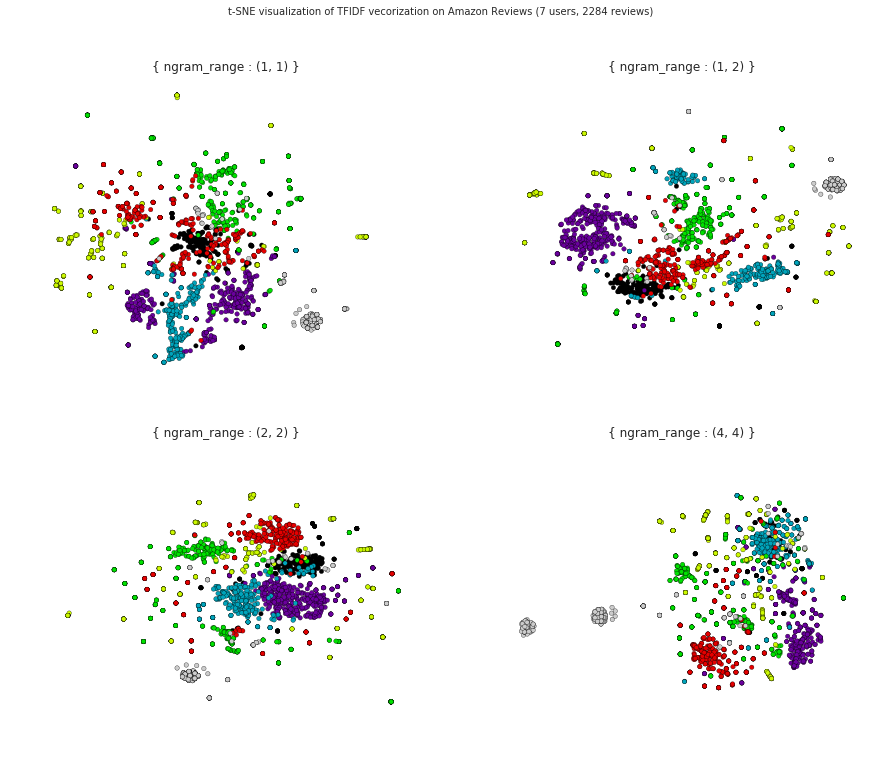

In [7]:
review_data_visualization(200, db, parameters)

### Preprocessor
A preprocessor function can be applied to words before they are counted and vectorized. A simple version of this is used to eliminate all punctuation that surrounds words. The expected result of this is to see more defined clusters.

In [8]:
PUNCTUATION = '`~!@#$%^&*()_-+={[}]|\:;"<,>.?/}\t\n'
def process(x):
    """
    Basic Preprocessor to remove punctuation from words. 
    """
    return x.strip(PUNCTUATION)

In [9]:
parameters = {
    'preprocessor':(None, process)
}

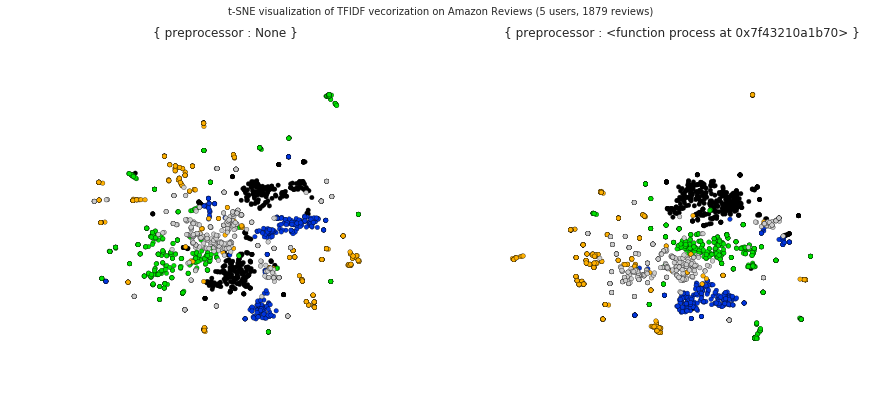

In [10]:
review_data_visualization(230, db, parameters)

### Maximum document frequency
The TFIDF Vectorizer allows for a maximum document frequency to be set that only considers terms that occur below a particular document frequency. This eliminates common words and focuses on the more unique phrasing of each user.  

In [11]:
parameters = {
    'max_df':(0.25, 1.0)
}

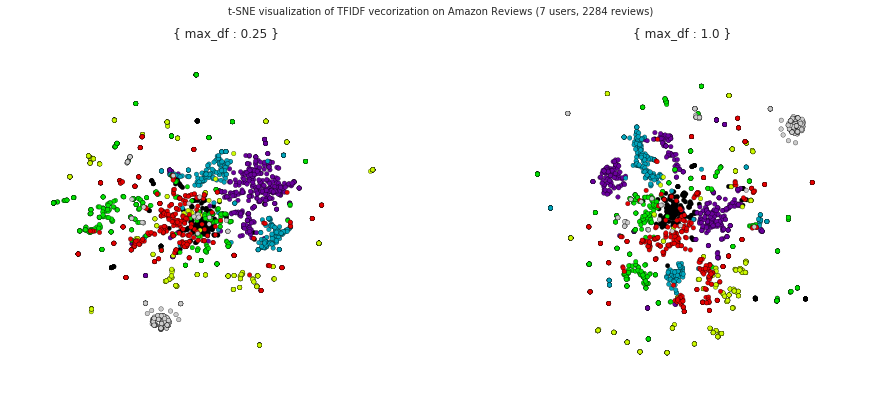

In [12]:
review_data_visualization(200, db, parameters)